In [ ]:
import subprocess
import sys
import random

cleanInstall = False
if cleanInstall==True:
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', 'numpy'])
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', 'torch'])

####Start importing installed packages
try:
    import numpy
except:
    print("Numpy import failed downloading")
    subprocess.run([sys.executable,'-m','pip','install','numpy'])
    import numpy
print(f"numpy version:{numpy.__version__}")

try:
    import torch
except:
    print("torch import failed downloading")
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'torch'])
    import torch
print(f"torch version:{torch.__version__}")
from torch.utils.data import DataLoader
from torch import nn

try:
    import torchvision
except:
    print("torchvision import failed downloading")
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'torchvision'])
    import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
print(f"torchvision version:{torchvision.__version__}")

try:
    import matplotlib
except:
    print("matplotlib import failed downloading")
    subprocess.run([sys.executable, '-m', 'pip', 'install', 'matplotlib'])
    import matplotlib
print(f"matplotlib version:{matplotlib.__version__}")
import matplotlib.pyplot as plt


try:
  from tqdm.auto import tqdm
except:
  print("tdqm import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'tdqm'])
  from tqdm.auto import tqdm

try:
  from pathlib import Path
except:
  print("pathlib import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'pathlib'])
  from pathlib import Path

try:
  import requests
except:
  print("requests import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'requests'])
  import requests
print (f"requests version: {requests.__version__}")

try:
  from timeit import default_timer as timer
except:
  print("timeit import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'requests'])
  from timeit import default_timer as timer

try:
  from torchmetrics import ConfusionMatrix
  import torchmetrics
except:
  print("torchmetrics import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'torchmetrics'])
  from torchmetrics import ConfusionMatrix
  import torchmetrics
print(f"torchmetrics version: {torchmetrics.__version__}")

try:
  from mlxtend.plotting import plot_confusion_matrix
  import mlxtend
except:
  print("mlxtend import failed downloading")
  subprocess.run([sys.executable, '-m', 'pip', 'install', 'mlxtend'])
  from mlxtend.plotting import plot_confusion_matrix
  import mlxtend
print(f"mlxtend version: {mlxtend.__version__}")


if(Path("helper_functions.py").is_file()):
  from helper_function import accuracy_fn
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)
  from helper_function import accuracy_fn

numpy version:1.26.4
torch version:2.6.0+cu124
torchvision version:0.21.0+cu124
matplotlib version:3.10.0
requests version: 2.32.3
torchmetrics version: 1.6.3
mlxtend version: 0.23.4


In [ ]:
class TinyVGG_recreation(nn.Module):
    """A recreation of model 2 and TinyVGG
    """
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super().__init__()
        self.convolution_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        #convo, relu conv relu maxpool
        self.convolution_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    def forward(self, x):
        x = self.convolution_block_1(x)
        x = self.convolution_block_2(x)
        x = self.classifier(x)
        return x

Main start
sample number: 0


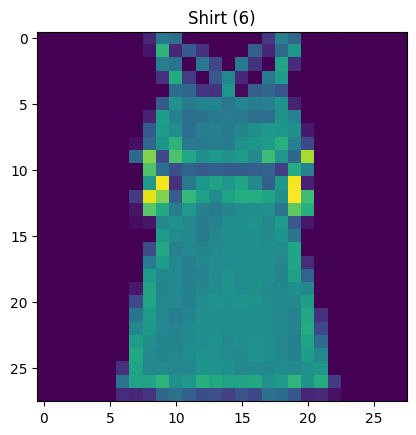

sample number: 1


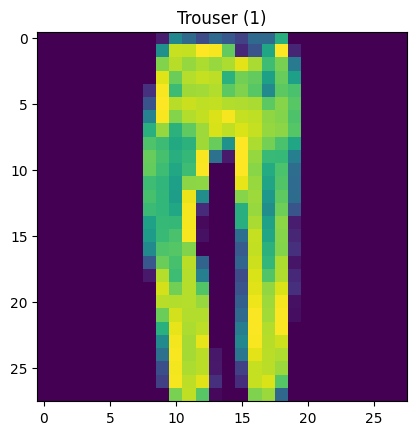

sample number: 2


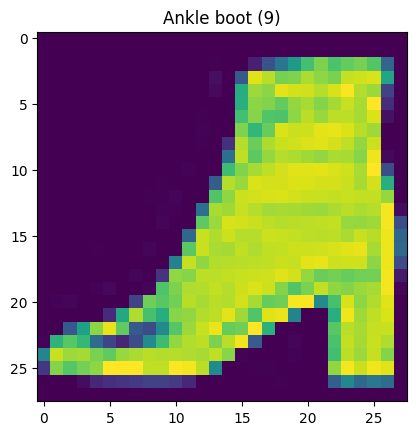

In [ ]:
print("Main start")
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(),target_transform=None)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(), target_transform=None)
class_names = test_data.classes
image_sample_count = 3
random.seed(42)
for sample_number in range(image_sample_count):
  print(f"sample number: {sample_number}")
  RandomSample = random.randint(0,len(train_data))
  image,label = train_data[RandomSample]
  plt.imshow(image.squeeze())
  plt.title(label=f"{class_names[label]} ({label})")
  plt.show()

train_dataloader = DataLoader(dataset=train_data, batch_size=32,shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [ ]:
def train_step(model:torch.nn,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"):
  train_loss, train_acc = 0, 0
  #train
  model.train()
  for batch, (x,y) in enumerate(data_loader):
    x,y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"train loss: {train_loss:.5f}, train accuracy:{train_acc:.2f}%")

def test_step(model:torch.nn,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device = "cuda" if torch.cuda.is_available() else "cpu"
              ):
  test_loss, test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for x, y in data_loader:
      x,y = x.to(device), y.to(device)
      test_pred = model(x)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
  print(f"test loss: {test_loss:.5f}, test accuracy {test_acc:.2f}%")


In [ ]:
model_0_cpu = TinyVGG_recreation(input_shape=1, output_shape=len(class_names),hidden_units=10).to("cpu")
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0_cpu.parameters(),lr=0.1)
train_time_cpu = []
train_time_cpu.append(timer())
epochs = 3
for epoch in tqdm(range(epochs)):
  train_step(model=model_0_cpu,data_loader=train_dataloader, loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device="cpu")
  test_step(model=model_0_cpu, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device="cpu")
train_time_cpu.append(timer())
print(f"total time on cpu {train_time_cpu[1]-train_time_cpu[0]}")

  0%|          | 0/3 [00:00<?, ?it/s]

train loss: 0.62683, train accuracy:76.97%
test loss: 0.43694, test accuracy 84.37%
train loss: 0.36053, train accuracy:86.95%
test loss: 0.36487, test accuracy 86.52%
train loss: 0.32125, train accuracy:88.41%
test loss: 0.32747, test accuracy 88.43%
total time on cpu 176.35432798600232


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_0_device = TinyVGG_recreation(input_shape=1, output_shape=len(class_names),hidden_units=10).to(device=device)
optimizer = torch.optim.SGD(params=model_0_device.parameters(), lr=0.1)
train_time_device = []
train_time_device.append(timer())
for epoch in tqdm(range(epochs)):
  train_step(model=model_0_device,data_loader=train_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,optimizer=optimizer,device=device)
  test_step(model=model_0_device,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)
train_time_device.append(timer())
print(f"Total time {train_time_device[1]- train_time_device[0]} on device {device}")

  0%|          | 0/3 [00:00<?, ?it/s]

train loss: 0.59686, train accuracy:78.34%
test loss: 0.41341, test accuracy 85.54%
train loss: 0.36851, train accuracy:86.77%
test loss: 0.35918, test accuracy 87.14%
train loss: 0.33150, train accuracy:88.01%
test loss: 0.32471, test accuracy 88.48%
Total time 166.46851666699877 on device cpu


In [ ]:
total_train_time_cpu = train_time_cpu[1]-train_time_cpu[0]
total_train_time_device = train_time_device[1]-train_time_device[0]
print(f'{"cpu is better" if total_train_time_cpu < total_train_time_device else "gpu is better" if total_train_time_device< total_train_time_cpu else "they are quite comprable."} by {abs(total_train_time_device - total_train_time_cpu):.2f} seconds')

gpu is better by 9.89 seconds


prediction:Sneaker, actual Sneaker


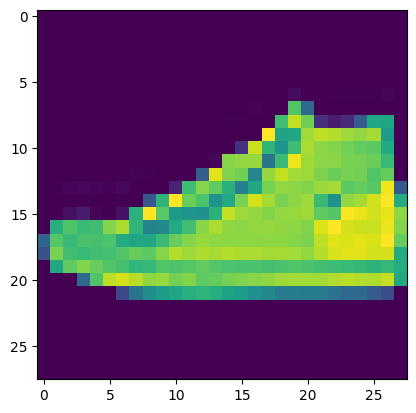

 prediction:Pullover, actual Coat


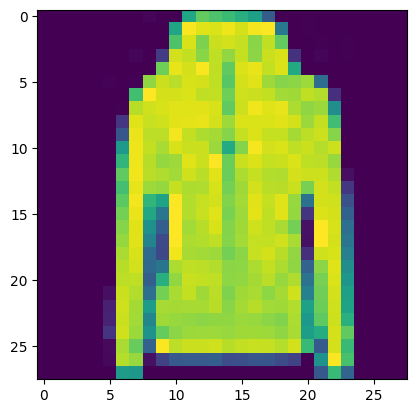

prediction:Dress, actual Dress


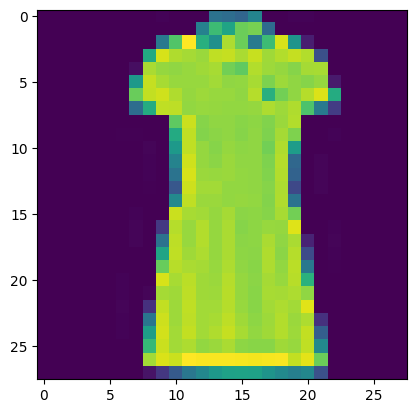

prediction:T-shirt/top, actual T-shirt/top


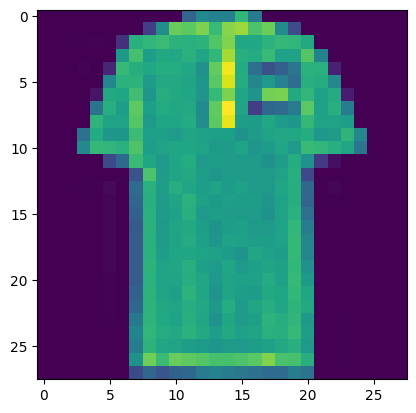

prediction:Coat, actual Coat


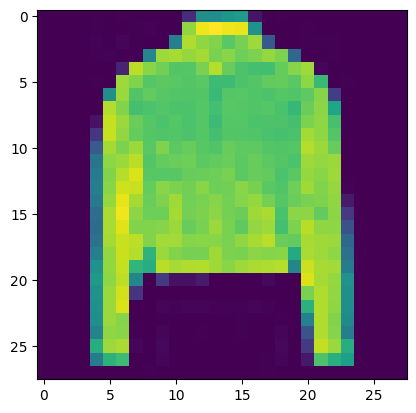

In [ ]:
number_of_samples = 5
with torch.inference_mode():
  for sample_number in range(number_of_samples):
    sample_key = random.randint(0,len(test_data))
    image, label = test_data[sample_key]
    pred_logit = model_0_device(torch.unsqueeze(input=image, dim=0).to(device=device))
    pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
    prediction = pred_prob.argmax(dim=0)
    textColor = "\033[91m " if prediction != label else "\033[92m"
    print(textColor +f"prediction:{class_names[prediction]}, actual {class_names[label]}"+"\033[00m")
    plt.imshow(image.squeeze())
    plt.show()


In [ ]:
y_preds = []
model_0_cpu.eval()
with torch.inference_mode():
  for x,y in tqdm(test_dataloader):
    x,y = x.to("cpu"), y.to("cpu")
    y_logits = model_0_cpu(x)
    y_pred = torch.softmax(y_logits.squeeze(),dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

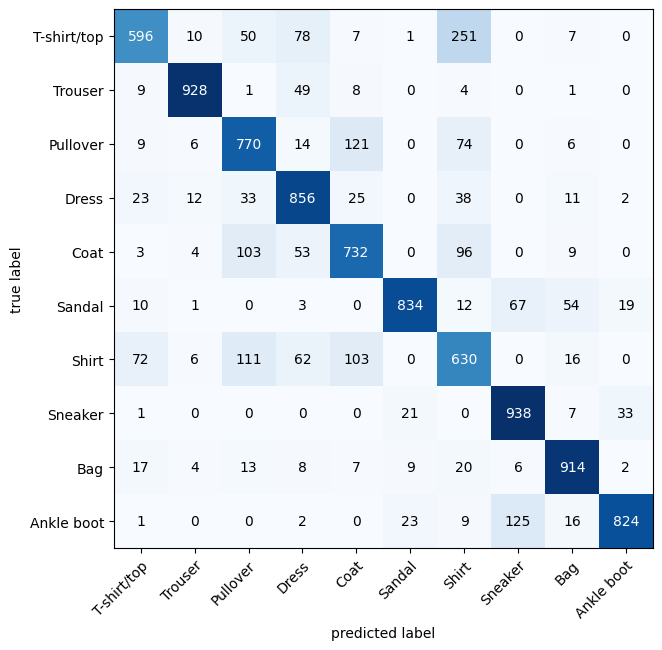

In [ ]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10,7))

In [ ]:
torch.manual_seed(42)
random_tensor = torch.randn(size=(1,3,64,64))
KernalSizeKing = 10
for ks in tqdm(range(1,KernalSizeKing)):
  convoExplore = nn.Conv2d(in_channels=3, out_channels=1,kernel_size=ks, stride=1, padding=1)
  print(f"kernal size:{ks}, output size:{convoExplore(random_tensor).shape}")

  0%|          | 0/9 [00:00<?, ?it/s]

kernal size:1, output size:torch.Size([1, 1, 66, 66])
kernal size:2, output size:torch.Size([1, 1, 65, 65])
kernal size:3, output size:torch.Size([1, 1, 64, 64])
kernal size:4, output size:torch.Size([1, 1, 63, 63])
kernal size:5, output size:torch.Size([1, 1, 62, 62])
kernal size:6, output size:torch.Size([1, 1, 61, 61])
kernal size:7, output size:torch.Size([1, 1, 60, 60])
kernal size:8, output size:torch.Size([1, 1, 59, 59])
kernal size:9, output size:torch.Size([1, 1, 58, 58])
